# Using Pytorch and fastai to classify different breeds of cats 🐈

To do this, we'll download various images of cats with different breeds through DuckDuckGO.
Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.





In [2]:
!pip install fastbook
import fastbook

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 33.9 MB/s 
     |████████████████████████████████| 186 kB 48.1 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 270 kB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from fastbook import *
from fastai.vision.widgets import *

### Getting images through DuckDuckgo

In [4]:
urls = search_images_ddg('dog',max_images=150)
len(urls), urls[0]

(200,
 'https://img2.grunge.com/img/gallery/the-dog-breed-that-once-hunted-lions/the-rhodesian-ridgeback-specialized-in-annoying-the-lion-1587055128.jpg')

In [5]:
cat_types = 'Asian', 'Australian Mist', 'Bengal',  'British Longhair', 'Cyprus', 'Bombay', 'Japanese Bobtail', 'Russian Blue', 'Selkirk Rex', 'Turkish Vankedisi'
path = Path('cats2')
if not path.exists():
  path.mkdir()
  for o in cat_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {o} cat')
    download_images(dest, urls=urls)

In [6]:
fns = get_image_files(path)
fns

(#2141) [Path('cats2/Bengal/00000221.jpg'),Path('cats2/Bengal/00000017.jpg'),Path('cats2/Bengal/00000084.jpg'),Path('cats2/Bengal/00000215.jpg'),Path('cats2/Bengal/00000193.jpg'),Path('cats2/Bengal/00000012.jpg'),Path('cats2/Bengal/00000152.jpg'),Path('cats2/Bengal/00000218.jpg'),Path('cats2/Bengal/00000272.jpg'),Path('cats2/Bengal/00000247.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#12) [Path('cats2/Bengal/00000107.jpg'),Path('cats2/Turkish Vankedisi/00000103.jpeg'),Path('cats2/Russian Blue/00000082.jpg'),Path('cats2/Bombay/00000182.jpg'),Path('cats2/Bombay/00000235.jpg'),Path('cats2/Bombay/00000128.jpg'),Path('cats2/Bombay/00000245.jpg'),Path('cats2/Bombay/00000126.jpg'),Path('cats2/Asian/00000186.png'),Path('cats2/British Longhair/00000131.jpg')...]

In [8]:
failed.map(Path.unlink);

### Datablock with fastai

In [9]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [10]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = cats.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


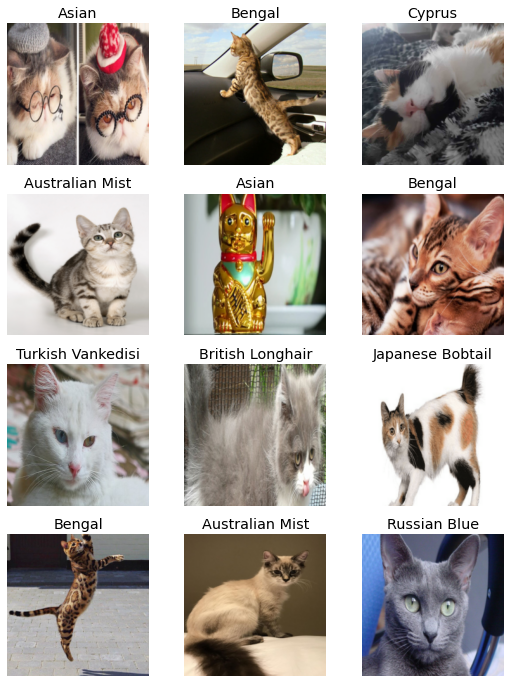

In [11]:
dls.valid.show_batch(max_n=12, nrows=4)

### FItting our resnet50 model

In [12]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
learn.fine_tune(epochs=10)

epoch,train_loss,valid_loss,error_rate,time
0,1.885613,1.195934,0.265882,01:13


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.045868,0.979720,0.223529,01:16
1,0.862796,0.918828,0.256471,01:16
2,0.742773,1.057276,0.247059,01:16
3,0.631476,0.970336,0.249412,01:17
4,0.498300,0.953069,0.261176,01:17
5,0.396142,0.808055,0.235294,01:16
6,0.312655,0.866558,0.216471,01:18
7,0.251450,0.822567,0.225882,01:17
8,0.202255,0.810020,0.216471,01:17
9,0.168919,0.823516,0.221176,01:16


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

### Confusion Matrix

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


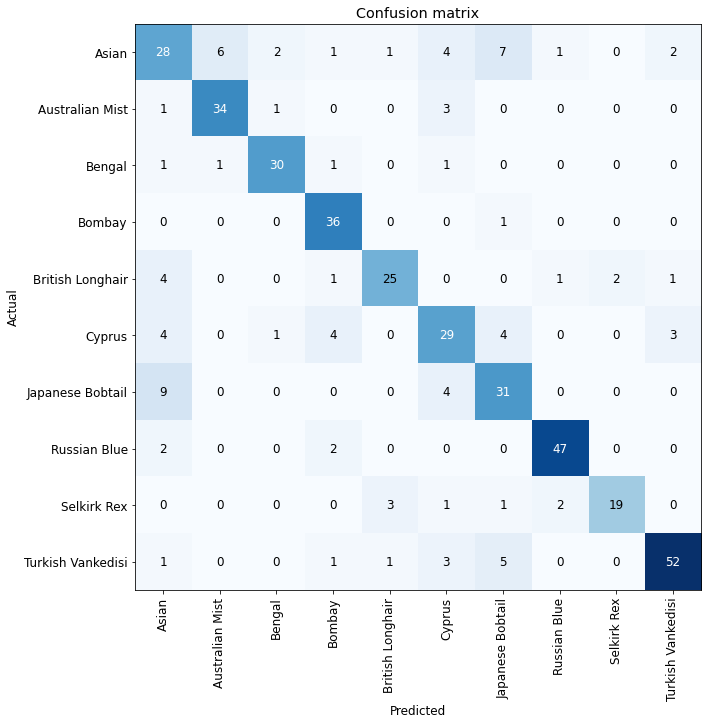

In [14]:
from IPython.core.pylabtools import figsize
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

### Plotting top 10 losses

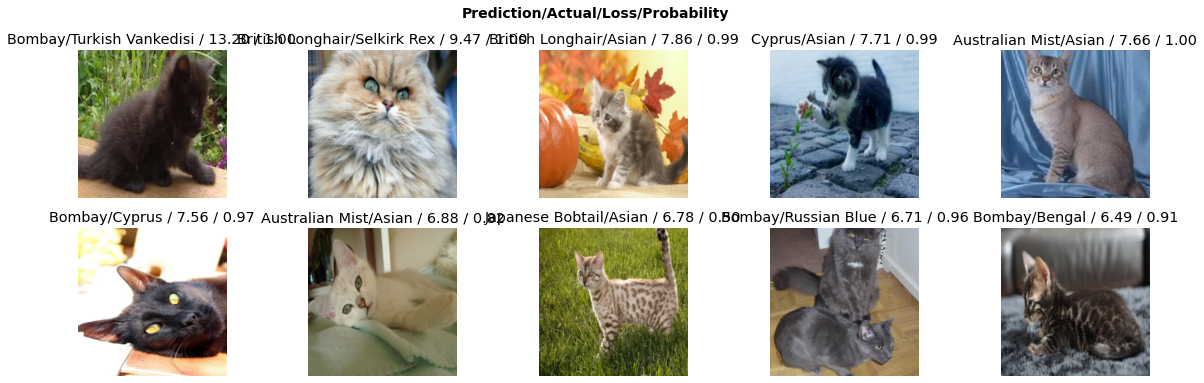

In [15]:
interp.plot_top_losses(10, nrows=2, figsize=(20,6))

### Saving our model

In [16]:
learn.export(fname='resnet50.pkl')

### Online APP

Converting our Jupyter notebook into online app with the help of voila and binder, so for that refer to another notebook i.e. **catbreed-classification-app.ipynb**